# Sod Shock Tube
### Context
The Sod shock tube problem is a classic test of the code's ability to handle discontinuities (i.e. shocks) and trace their propagation. This is a simple example of a [Riemann problem](https://en.wikipedia.org/wiki/Riemann_problem), which is essentially just an initial-value problem for which we have a conservation equation subject to a piecewise discontinuous constant initial condition. In the case of the Sod shock tube, this amounts to having a fluid separated into two constant states, separated by some boundary/diaphragm across which the density and pressure are discontinuous. Formally, this can be written:

$$ \rho(x)=   \left\{
\begin{array}{ll}
      \rho_L & x\leq x_\mathrm{crit} \\
      \rho_R & x>x_\mathrm{crit} \\
\end{array} 
\right.  
$$

and

$$ P(x)=   \left\{
\begin{array}{ll}
      P_L & x\leq x_\mathrm{crit} \\
      P_R & x>x_\mathrm{crit} \\
\end{array} 
\right.  
$$

where the subscripts correspond to the 'left' and 'right' sides of the boundary at $x=x_\mathrm{crit}$. Generally, we will define $P_L$ and $P_R$ such that $P_R < P_L$. The following figure of the initial setup ($t=0$) for the 1D shock tube.

![Sod Setup](sod_setup.png)

At $t=0$, the diaphragm is removed, and, because the fluid is initially at rest, this will initiate a flow from the higher pressure (left) to lower pressure (right) region. Conceptually, in an attempt to equalize te pressure, the fluid on the left will expand and flow into the right section, compressing the fluid there. This rarefaction occurs in a region known as the 'expansion fan' (2 in the diagram) that proceeds to the left, and, similarly, the compression proceeds to the right as a 'shock front' (the line separating 4 and 5 in the diagram). There is a 'boundary' between these two regions (the expanding and compressing fluids) across which the state variables of the fluid are discontinuous – this is the source of the difficulty for the code and is why this provides a good test. The following figure is a schematic visualization of what the aforementioned process looks like at $t>0$.

![Sod Final](solution_sod.png)

Functionally, we need to solve the Euler equations to trace the evolution of the system over time and this corresponds to the aforementioned Riemann problem that we are solving. First, the Euler equations can be written in matrix form as follows (assuming no external body forces):

$$
\frac{\partial}{\partial t}\begin{pmatrix} \rho \\ \rho v \\ E \end{pmatrix} + \frac{\partial}{\partial x}\begin{pmatrix} \rho v\\ \rho v^2 + P \\ (E+P)v \end{pmatrix} = 0
$$

where the first equation is the continuity equation, the second is momentum conservation/the 'Euler' equation (flux of momentum density has an ordered component and pressure/random motion component), and the third is the energy conservation equation (energy flux similarly has a bulk transport component and pressure-driven component). In these equations, $\rho$ is the density, $P$ is the pressure, $E$ is the energy, and $v$ is the average velocity. In order to close the system, we need to specify an equation of state, so here we choose the polytropic EOS for an ideal gas, with $\gamma = 1.4$ (the ratio of specific heats is that of air). 

Using expressions derived from the characteristic form of the Euler equations (such as the Riemann invariants and the Rankine-Hugoniot shock jump conditions), we can relate the fluid quantities on either side of the shock, the expansion fan, and the contact discontinuity. With a lot of algebra, one can derive an implicit expression for the ratio of the *known* $p_1$ and $p_5$ pressures on either side of the diaphragm initially in terms of the ratio of *unknown* pressures $p_3$ and $p_4$ on either side of the contact. This can be solved iteratively, but this is often expensive, so we can use codes, such as this one, to approximate the solution more efficiently.

### Using the code
In any case, this is the perfect example of a situation where the code can be used to solve this Riemann problem. First, we can `import phd`.

In [1]:
import phd
import numpy as np

Now we need to set-up our particle grid. Here, we will be producing a two-dimensional grid of particles with the `HydroParticleCreator` method but for convenience, can package it all into a single method as below. This is useful if we were to, for example, initialize the code in parallel, rather than serial, as we can feed the `create_particles` method in as an argument to the `distribute_initial_particles` method. However, for our purposes, the serial implementation is sufficient, so `distribute_initial_particles` simply reduces to the method we have defined below. If we wanted to run the code in parallel, however, it would suffice to bundle all these code blocks into a single python program and use the command 
```
mpirun -n 4 python your_program_name.py
``` 
for example and this implementation should work just fine.

For specific values, we have chosen to take $\rho_L = 1$, $\rho_R = 0.125$, $P_L = 1$, $P_R = 0.1$, and the initial velocity is 0 in both the $x$ and $y$ directions.

In [2]:
def create_particles(dim=2, nx=100, Lx=1.0, diaphragm=0.5, gamma=1.4, units = "cgs"):

    dx = Lx/nx # spacing between particles
    n = nx*nx  # number of particles

    # create particle container
    particles, units = phd.HydroParticleCreator(n, dim=2, unit_sys = units)
    part = 0
    for i in range(nx):
        for j in range(nx):
            particles["position-x"][part] = (i+0.5)*dx
            particles["position-y"][part] = (j+0.5)*dx 
            particles["ids"][part] = part
            part += 1

    # set ambient values
    particles["density"][:]  = 1.0                 # rho_L
    particles["pressure"][:] = 1.0                 # P_L
    particles["velocity-x"][:] = 0.0
    particles["velocity-y"][:] = 0.0

    cells = particles["position-x"] > diaphragm    # subset of particles to the right of the 'diaphragm'
    particles["density"][cells] = 0.125            # rho_R
    particles["pressure"][cells] = 0.1             # P_R

    return particles, units

dim = 2; gamma = 1.4            # specify dimension and specific heat ratio
# useful for parallelizing the implementation, in serial, this does nothing
particles, units = phd.distribute_initial_particles(create_particles, dim=dim, gamma=gamma, units = "cgs") 

Though the ``HydroParticleCreator`` method was implicitly used within ``create_particles`` above and the ``Units`` object generated there, it might be instructive to redefine the ``Units`` object ourselves. This will serve as a useful demonstration of how one can construct a ``Units`` object directly. First we import the ``Units`` class and then we can initialize the object, specifying that we are working in cgs. If we do not specify an output system, the code will automatically assume the same unit system for producing output.

In [3]:
from phd.utils.units import Units
units = Units(unit_system = "cgs")

units.get_bases() # print the base dimensions used to define this unit system

cgs Unit System
 Base Units:
  length: cm
  mass: g
  time: s
  temperature: K
  angle: rad
  luminous_intensity: cd
  logarithmic: Np
 Other Units:
  energy: erg
  specific_energy: erg/g
  pressure: dyn/cm**2
  force: dyn
  magnetic_field_cgs: G
  charge_cgs: statC
  current_cgs: statA
  power: erg/s

Next, we can specify the domain, construct the mesh, initialize the integrator object, set the stopping conditions, and specify the outputs we want to receive.

In [4]:
# computation related to boundaries
domain_manager = phd.DomainManager(
        xmin=[0., 0.], xmax=[1., 1.],
        initial_radius=0.1)

# create voronoi mesh
mesh = phd.Mesh(regularize=False)

# computation
integrator = phd.MovingMeshMUSCLHancock()
integrator.set_mesh(mesh)
integrator.set_riemann(phd.HLLC())
integrator.set_particles(particles)
integrator.set_domain_manager(domain_manager)
integrator.set_boundary_condition(phd.Reflective())
integrator.set_reconstruction(phd.PieceWiseLinear())
integrator.set_equation_state(phd.IdealGas(gamma=gamma))
integrator.set_units(units)

sim_name = "sod"
# if the code has been initialized in parallel
if phd._in_parallel:
    integrator.set_load_balance(phd.LoadBalance())
    sim_name = "mpi_sod"

# add finish criteria
simulation_time_manager = phd.SimulationTimeManager()
simulation_time_manager.add_finish(phd.Time(time_max=0.15))

# output last step
output = phd.FinalOutput()
output.set_writer(phd.Hdf5())
simulation_time_manager.add_output(output)

Finally, we can create the simulation and let it run.

In [5]:
# Create simulator
simulation = phd.Simulation(simulation_name=sim_name, log_level = "startup")
simulation.set_integrator(integrator)
simulation.set_simulation_time_manager(simulation_time_manager)
simulation.initialize()
simulation.solve()

phd: [WARNING  ] 2021-07-28 10:40:32,583: Directory sod_output already exists, files maybe over written!
phd: [WARNING  ] 2021-07-28 10:40:32,587: Directory sod_output/final_output already exists, files maybe over written!
phd: [STARTUP  ] 2021-07-28 10:40:32,589: 

 __________.__         .___
\______   \  |__    __| _/
 |     ___/  |  \  / __ |
 |    |   |   Y  \/ /_/ |
 |____|   |___|  /\____ |
               \/      \/
Welcome to Python Hydro-Dynamics!

Simulation Information
------------------------------
Running in serial
Log file saved at: sod.log
Problem solving: sod
Output data will be saved at: sod_output

Classes used in the simulation
------------------------------
boundary_condition: Reflective
domain_manager: DomainManager
equation_state: IdealGas
integrator: MovingMeshMUSCLHancock
mesh: Mesh
particles: CarrayContainer
reconstruction: PieceWiseLinear
riemann: HLLC
units: Units

phd: [WARNING  ] 2021-07-28 10:40:45,762: Directory sod_output/final_output/final_output0000 alr

Now we can read in the output file, which has been placed into the 'sod_output/final_output' folder and plot the pressure, density, and velocity profiles.

phd: [INFO     ] 2021-07-21 12:17:42,386: hdf5 format: Reading filename sod_output/final_output/final_output0000/final_output0000.hdf5


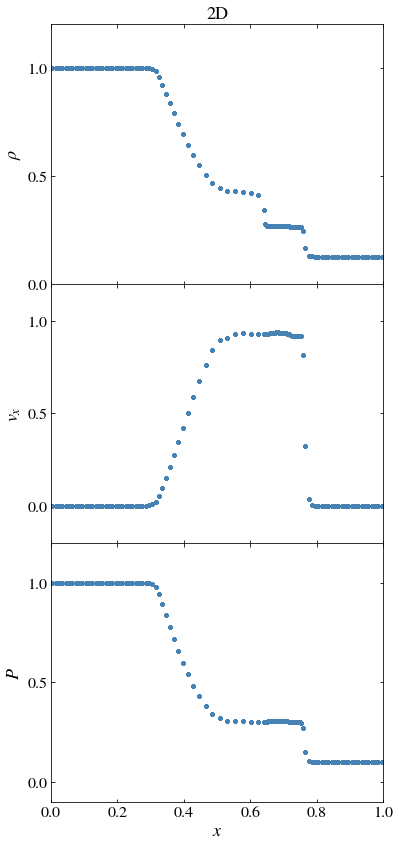

In [6]:
# For plotting...
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
%matplotlib inline

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams["xtick.labelsize"] = 16
mpl.rcParams["ytick.labelsize"] = 16

# Reading in the output
file_name="sod_output/final_output/final_output0000/final_output0000.hdf5"
reader = phd.Hdf5()
sod, units = reader.read(file_name)

fig, axes = plt.subplots(3, 1, sharex="col", figsize=(6,12))
fig.subplots_adjust(hspace=0, left=0.13, top=0.96, bottom=0.06)

ax = axes[0]
ax.plot(sod["position-x"], sod["density"], ".", color="steelblue")
ax.set_xlim(0,1)
ax.set_ylim(0,1.2)
ax.set_yticks([0.0, 0.5, 1.0])
ax.set_yticklabels([0.0, 0.5, 1.0])
ax.set_ylabel(r"$\rho$", fontsize=18)
ax.tick_params(direction="in", right=True, top=True)
ax.set_title("2D", fontsize=18)

ax = axes[1]
ax.plot(sod["position-x"], sod["velocity-x"], ".", color="steelblue")
ax.set_xlim(0,1)
ax.set_ylim(-0.2,1.2)
ax.set_yticks([0.0, 0.5, 1.0])
ax.set_yticklabels([0.0, 0.5, 1.0])
ax.set_ylabel(r"$v_x$", fontsize=18)
ax.tick_params(direction="in", right=True, top=True)

ax = axes[2]
ax.plot(sod["position-x"], sod["pressure"], ".", color="steelblue")
ax.set_xlim(0,1)
ax.set_ylim(-0.1,1.2)
ax.set_yticks([0.0, 0.5, 1.0])
ax.set_yticklabels([0.0, 0.5, 1.0])
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$P$", fontsize=18)
ax.tick_params(direction="in", right=True, top=True)

plt.show()